# Mini-démo de transfert de timbres avec spectrogrammes

---

### Importation de bibliothèques nécessaires

In [1]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Flatten, Reshape
from scipy.io.wavfile import write
import soundfile as sf

2025-01-30 13:29:34.266874: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-30 13:29:34.414889: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-30 13:29:34.551570: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1738240174.674185 1357585 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1738240174.708066 1357585 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-30 13:29:34.999322: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

In [2]:
from tensorflow.keras import backend as K
K.set_floatx('float32')  # Réduit l'utilisation mémoire


---

### Fonction pour charger l'audio et calculer le spectrogramme

In [3]:
def load_audio(file_path, sr=22050, duration=9):
    audio, _ = librosa.load(file_path, sr=sr, duration=duration)
    spectrogram = librosa.stft(audio, n_fft=1024, hop_length=512)
    magnitude, phase = librosa.magphase(spectrogram)
    return audio, magnitude, phase

---

### Fonction pour reconstruire l'audio

In [4]:
def reconstruct_audio(magnitude, phase, sr=22050):
    spectrogram = magnitude * phase
    audio = librosa.istft(spectrogram, hop_length=512)
    return audio

---

### Fonction pour calculer l'énergie

In [5]:
def signal_energy(audio):
    return np.sum(audio**2) / len(audio)

---

### Construction d'un auto-encodeur simple pour le transfert de timbre

In [6]:
def build_simple_autoencoder(input_shape):
    encoder = Sequential([
        Flatten(input_shape=input_shape),
        Dense(128, activation='relu'),
        Dense(64, activation='relu')
    ])

    decoder = Sequential([
        Dense(128, activation='relu', input_shape=(64,)),
        Dense(np.prod(input_shape), activation='sigmoid'),
        Reshape(input_shape)
    ])

    input_layer = Input(shape=input_shape)
    encoded = encoder(input_layer)
    decoded = decoder(encoded)

    autoencoder = Model(inputs=input_layer, outputs=decoded)
    autoencoder.compile(optimizer='adam', loss='mse')
    return autoencoder

---

### Chargement et préparation des audios

In [7]:
source_audio_path = 'data/source/guitare_source.wav'  # Placez ici le fichier audio source (par exemple, une voix ou un instrument). Vous pouvez trouver des exemples de fichiers audio libres de droits sur des sites comme [Freesound](https://freesound.org/) ou utiliser vos propres enregistrements.
cible_audio_path = 'data/cible/piano_cible.wav'   # Placez ici le fichier audio cible (par exemple, un instrument différent ou une autre voix).

source_audio, source_mag, source_phase = load_audio(source_audio_path)
cible_audio, cible_mag, _ = load_audio(cible_audio_path)

print("Énergie Source :", signal_energy(source_audio))
print("Énergie Cible :", signal_energy(cible_audio))
# Normaliser les spectrogrammes
source_mag_norm = source_mag / np.max(source_mag)
cible_mag_norm = cible_mag / np.max(cible_mag)


Énergie Source : 0.0055512404
Énergie Cible : 0.0041093165


---

### Entraînement de l'auto-encodeur

In [8]:
input_shape = source_mag_norm.shape
print("Taille du spectrogramme source :", input_shape)
autoencoder = build_simple_autoencoder(input_shape)

# Entraînement sur des données simplifiées
autoencoder.fit(source_mag_norm[np.newaxis, ..., np.newaxis], 
                cible_mag_norm[np.newaxis, ..., np.newaxis], 
                epochs=10, batch_size=1)


Taille du spectrogramme source : (513, 388)


/home/nabil/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
2025-01-30 13:29:41.943219: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
/home/nabil/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.2479
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 690ms/step - loss: 0.2478
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 682ms/step - loss: 0.2477
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 636ms/step - loss: 0.2475
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 636ms/step - loss: 0.2469
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 673ms/step - loss: 0.2451
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 644ms/step - loss: 0.2401
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 667ms/step - loss: 0.2291
Epoch 9/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 0.2089
Epoch 10/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 625ms/step - loss: 0.1771


In [9]:
print("Taille d'entrée du modèle :", autoencoder.input_shape)
print("Taille de sortie du modèle :", autoencoder.output_shape)

Taille d'entrée du modèle : (None, 513, 388)
Taille de sortie du modèle : (None, 513, 388)


---

### Transfert de timbre et reconstruction audio

In [10]:
transferred_mag_norm = autoencoder.predict(source_mag_norm[np.newaxis, ..., np.newaxis])
print("Shape de la sortie réelle de predict():", transferred_mag_norm.shape) 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
Shape de la sortie réelle de predict(): (1, 513, 388)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Max transferred_mag : 32.235252
Min transferred_mag : 12.224059
Énergie Transférée : 0.36722094
Énergie Transférée APRES normalisation: 0.0041093165
shape transferred_audio :  (198144,)
Énergie Source : 0.0055512404
Énergie Cible : 0.0041093165
Énergie Transféré : 0.0041093165


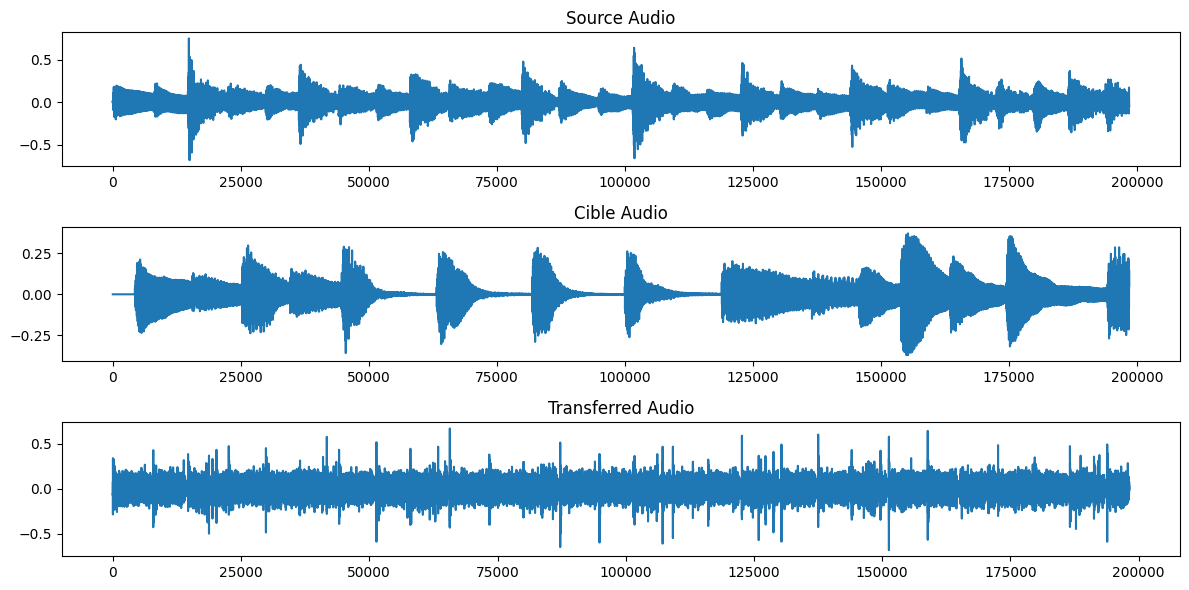

In [11]:
transferred_mag_norm = autoencoder.predict(source_mag_norm[np.newaxis, ..., np.newaxis])
transferred_mag = transferred_mag_norm * np.max(source_mag)
print("Max transferred_mag :", np.max(transferred_mag))
print("Min transferred_mag :", np.min(transferred_mag))


# transferred_mag = np.reshape(transferred_mag, source_mag.shape)
transferred_audio = reconstruct_audio(transferred_mag, source_phase)[0] * 0.75
print("Énergie Transférée :", signal_energy(transferred_audio))
transferred_audio *= np.sqrt(signal_energy(cible_audio) / signal_energy(transferred_audio))
print("Énergie Transférée APRES normalisation:", signal_energy(transferred_audio))

print("shape transferred_audio : ", transferred_audio.shape)
# transferred_audio = transferred_audio / np.max(np.abs(transferred_audio))  # Normalisation dans [-1, 1]

transferred_audio_int16 = (transferred_audio * 32767).astype(np.int16)

print("Énergie Source :", signal_energy(source_audio))
print("Énergie Cible :", signal_energy(cible_audio))
print("Énergie Transféré :", signal_energy(transferred_audio))

plt.figure(figsize=(12, 6))
plt.subplot(3, 1, 1)
plt.plot(source_audio)
plt.title("Source Audio")

plt.subplot(3, 1, 2)
plt.plot(cible_audio)
plt.title("Cible Audio")

plt.subplot(3, 1, 3)
plt.plot(transferred_audio)
plt.title("Transferred Audio")

plt.tight_layout()
plt.show()



# Sauvegarder l'audio transformé
write('data/transferred/transferred_audio.wav', 22050, transferred_audio_int16)
# sf.write('transferred_audio.wav', transferred_audio, 22050, 'PCM_16')


---

### Visualisation du spectrograme

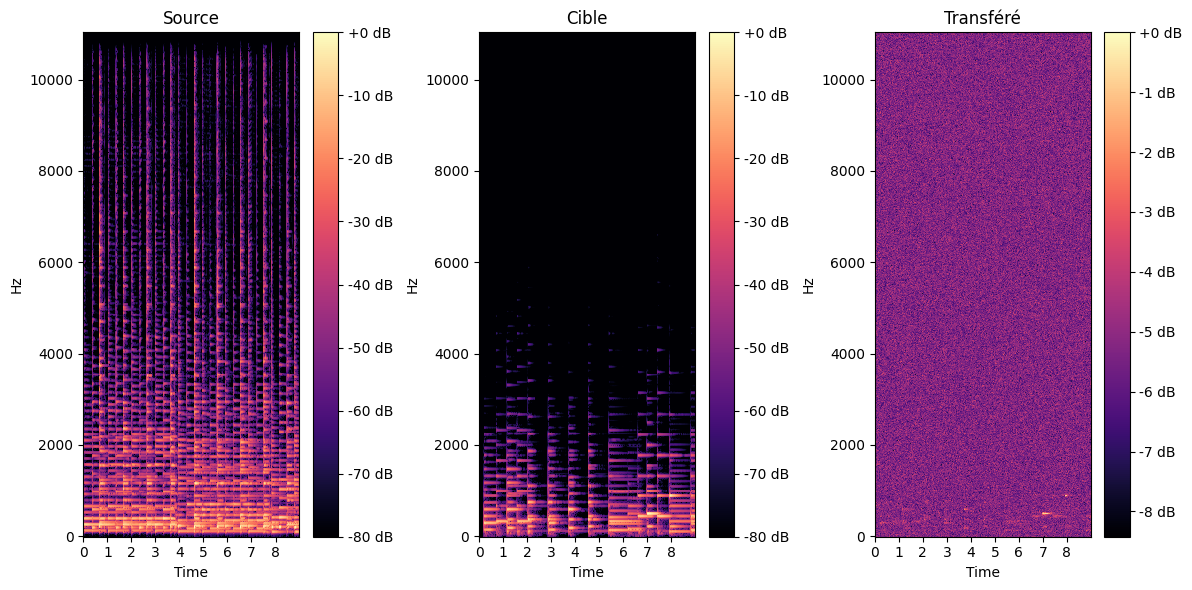

In [12]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
librosa.display.specshow(librosa.amplitude_to_db(source_mag, ref=np.max), sr=22050, x_axis='time', y_axis='hz')
plt.title('Source')
plt.colorbar(format='%+2.0f dB')

plt.subplot(1, 3, 2)
librosa.display.specshow(librosa.amplitude_to_db(cible_mag, ref=np.max), sr=22050, x_axis='time', y_axis='hz')
plt.title('Cible')
plt.colorbar(format='%+2.0f dB')

plt.subplot(1, 3, 3)
librosa.display.specshow(librosa.amplitude_to_db(np.squeeze(transferred_mag), ref=np.max), sr=22050, x_axis='time', y_axis='hz')
plt.title('Transféré')
plt.colorbar(format='%+2.0f dB')

plt.tight_layout()
plt.show()
